In [1]:
# This code works in Python 3.10.6
import numpy as np
import pandas as pd
import networkx as nx
import dgl
from torch_geometric.datasets.dblp import DBLP
import torch
from torch import optim
import torch_geometric.utils.convert
import torch_geometric.transforms as T
from collections import Counter
import itertools
import os
import glob
import warnings
warnings.filterwarnings('ignore')

In [2]:
import sys  
sys.path.insert(1, '../../../../../../../evaluation/')
sys.path.insert(1, '../../../../../../../evaluation/model/')
sys.path.insert(1, '../../../../../../../evaluation/postprocessing/')
sys.path.insert(1, '../../../../../../../evaluation/select_explanation/')

In [3]:
import plots
import utils
import dblp_model as GNN
import dblp_postprocessing as postprocessing
import dblp_select_explanation as select_explanation

In [4]:
FEATURE_SIZE = 50
RUNS = 10

Create Metagraph

In [5]:
dataset = DBLP(root='./dblp_data', transform=T.Constant(node_types='conference'))
data = dataset[0]
data['conference'].pop('num_nodes')
#Create metagraph
g = torch_geometric.utils.convert.to_dgl(data)
meta_g= g.metagraph()

In [6]:
dataset = DBLP(root='./dblp_data', transform=T.Constant(node_types='conference'))
data = dataset[0]
print(data)

HeteroData(
  author={
    x=[4057, 334],
    y=[4057],
    train_mask=[4057],
    val_mask=[4057],
    test_mask=[4057],
  },
  paper={ x=[14328, 4231] },
  term={ x=[7723, 50] },
  conference={
    num_nodes=20,
    x=[20, 1],
  },
  (author, to, paper)={ edge_index=[2, 19645] },
  (paper, to, author)={ edge_index=[2, 19645] },
  (paper, to, term)={ edge_index=[2, 85810] },
  (paper, to, conference)={ edge_index=[2, 14328] },
  (term, to, paper)={ edge_index=[2, 85810] },
  (conference, to, paper)={ edge_index=[2, 14328] }
)


In [7]:
#all classes
# Feature selection for Author node
imp_feat_author = utils.selected_features_var(data['author'].x, threshold=0.948).iloc[:, : FEATURE_SIZE]
imp_feat_author

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4052,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4053,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4054,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4055,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
# Paper
paper = data['paper'].x.tolist()
df_paper = pd.DataFrame(paper)
imp_feat_paper = utils.selected_features_var(df_paper, threshold=0.9845).iloc[:, : FEATURE_SIZE]
imp_feat_paper

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14323,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14324,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
14325,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14326,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
data['author'].x = torch.tensor(imp_feat_author.values).to(dtype=torch.float32)
data['paper'].x = torch.tensor(imp_feat_paper.values).to(dtype=torch.float32)

In [8]:
data

HeteroData(
  author={
    x=[4057, 50],
    y=[4057],
    train_mask=[4057],
    val_mask=[4057],
    test_mask=[4057],
  },
  paper={ x=[14328, 50] },
  term={ x=[7723, 50] },
  conference={
    num_nodes=20,
    x=[20, 1],
  },
  (author, to, paper)={ edge_index=[2, 19645] },
  (paper, to, author)={ edge_index=[2, 19645] },
  (paper, to, term)={ edge_index=[2, 85810] },
  (paper, to, conference)={ edge_index=[2, 14328] },
  (term, to, paper)={ edge_index=[2, 85810] },
  (conference, to, paper)={ edge_index=[2, 14328] }
)

In [13]:
#List of edges in metagraph of DBLP
list(meta_g.edges())

[('author', 'paper'),
 ('paper', 'author'),
 ('paper', 'conference'),
 ('paper', 'term'),
 ('conference', 'paper'),
 ('term', 'paper')]

In [9]:
graphs_path = '../../../../../../../graph generator/baseline_vae/sampled_graphs_vae/'
print('Original no of graphs:',len([name for name in glob.glob(graphs_path + 'dblp/*')]))

Original no of graphs: 1536


In [20]:
avg_max_pred_list = []
max_pred_list = []
graph_dict_list = []
softmax_dict_list = []
nodefeature_dict_list = []
all_edges_list = []
class_graphid_list = []

In [22]:
for i in range(0,RUNS):     
    counter = i
    model = GNN.HeteroGNN(data.metadata(), hidden_channels=64, out_channels=4,
                  num_layers=2)
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    data, model = data.to(device), model.to(device)
    
    with torch.no_grad():  # Initialize lazy modules.
        out = model(data.x_dict, data.edge_index_dict)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=0.001)
      
    best_val_acc = 0
    start_patience = patience = 100
    for epoch in range(1, 700):
        loss = GNN.train(data,model,optimizer)
        train_acc, val_acc, test_acc = GNN.test(data,model)
        if epoch%200==0:
            print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train: {train_acc:.4f}, '
              f'Val: {val_acc:.4f}, Test: {test_acc:.4f}')
    
        if best_val_acc <= val_acc:
            patience = start_patience
            best_val_acc = val_acc
        else:
            patience -= 1
    
        if patience <= 0:
            print('Stopping training as validation accuracy did not improve '
                  f'for {start_patience} epochs')
            break

        
    all_edges = {}
    softmax_dict = {}
    nodefeature_dict = {}
    graph_dict = {}
    rootdir = graphs_path + 'dblp/'

    dir_list = []
    for subdir, dirs,files in os.walk(rootdir):
        
        if files:
            graph_path = os.path.join(subdir, files[0])
            class_path = os.path.join(subdir, files[1])       
            feature_path = os.path.join(subdir, files[2])
            
            graph = nx.read_gexf(graph_path)
            filename = os.path.basename(graph_path)
            graph_id= filename.split('.')[0]
            
            nodeId_list = []
            
            for key, value in graph.nodes(data=True):
                nodeId_list.append(key)
                edges = [e for e in graph.edges]
                
            node_type_list = torch.load(class_path).detach().numpy()
            
            df_graph = pd.DataFrame()
            df_graph["nodeId"] = nodeId_list
            df_graph["class"] = node_type_list
      
            #removing the node type features
            df_feature = pd.DataFrame(torch.load(feature_path).detach().numpy()).iloc[:, : FEATURE_SIZE]        
            df_feature["class"] = node_type_list                
            
            author_node_features = utils.apply_threshold(df_feature[df_feature['class'] == 1].drop(['class'], axis = 1))
    
            labels = []
            unique_labels = [0,1,2,3]
    
            for i in range(0,len(author_node_features)):
                labels.append(random.choice(unique_labels))
                
            author_node_features['class']= labels
    
            paper_node_features = utils.convert_to_discrete(df_feature[df_feature['class'] == 0].drop(['class'], axis = 1))
            term_node_features = df_feature[df_feature['class'] == 2].drop(['class'], axis = 1)
    
            conf_nodes = df_graph[df_graph['class'] == 3].drop(['class'], axis = 1)
        
            small_graph_data, removed_edges, graph_edges = postprocessing.create_dataset(nodeId_list,edges,
                                    author_node_features,paper_node_features,
                                    term_node_features,conf_nodes,graph_id,df_graph)
        
            all_edges.update(graph_edges)
            edge_list = all_edges[graph_id]
            graph = nx.Graph(edge_list)
            if not nx.is_empty(graph) and nx.is_connected(graph):
        
                if (small_graph_data['author'].x.nelement()!=0) and \
                (small_graph_data['paper','to','author']) and \
                (small_graph_data['author','to','paper']) and \
                (small_graph_data['paper','to','conference']) and \
                (small_graph_data['paper','to','term']):
                    
                    small_graph_data= small_graph_data.to(device)
                    softmax = select_explanation.evaluate_gnn(small_graph_data,model)
                    softmax_dict[graph_id] = softmax
                    nodefeature_dict[graph_id]={'author':small_graph_data['author'].x,
                                                     'paper':small_graph_data['paper'].x,
                                                     'term':small_graph_data['term'].x}
                    graph_dict[graph_id]=df_graph
    
    print("No. of graphs evaluated: ",len(softmax_dict))

    avg_max_pred, max_pred, class_graphid = select_explanation.get_max_pred(softmax_dict,counter)
    
    avg_max_pred_list.append(avg_max_pred)
    max_pred_list.append(max_pred)
    graph_dict_list.append(graph_dict)
    softmax_dict_list.append(softmax_dict)
    nodefeature_dict_list.append(nodefeature_dict)
    all_edges_list.append(all_edges)
    class_graphid_list.append(class_graphid)

No. of graphs evaluated:  200
Run0 0.9556440114974976 0.2232683300971985 0.9985892176628113 0.21152736246585846
No. of graphs evaluated:  200
Run1 0.8529714345932007 0.16063521802425385 0.9939828515052795 0.19045667350292206
No. of graphs evaluated:  200
Run2 0.5966095328330994 0.21634893119335175 0.9962242841720581 0.5347983837127686
No. of graphs evaluated:  200
Run3 0.8872580528259277 0.25535067915916443 0.9956023693084717 0.2973405718803406
No. of graphs evaluated:  200
Run4 0.9966617822647095 0.2110060304403305 0.9974333643913269 0.14914099872112274
No. of graphs evaluated:  200
Run5 0.9941482543945312 0.20086771249771118 0.9858026504516602 0.20608268678188324
No. of graphs evaluated:  200
Run6 0.9745023846626282 0.4234340786933899 0.9772720336914062 0.18156400322914124
No. of graphs evaluated:  200
Run7 0.8830345869064331 0.3808104395866394 0.9905999302864075 0.1689072549343109
No. of graphs evaluated:  200
Run8 0.899296760559082 0.23854976892471313 0.9947681427001953 0.186556443

In [23]:
avg_max_pred_list

[0.5972572304308414,
 0.549511544406414,
 0.5859952829778194,
 0.6088879182934761,
 0.5885605439543724,
 0.5967253260314465,
 0.6391931250691414,
 0.6058380529284477,
 0.5797927789390087,
 0.6587098240852356]

In [24]:
print('Mean',np.mean(avg_max_pred_list))

Mean 0.6010471627116203


In [25]:
print('Standard Deviation',np.std(avg_max_pred_list))

Standard Deviation 0.02896154763160931


In [26]:
m = max(avg_max_pred_list)
index = avg_max_pred_list.index(m)
index

9

In [32]:
class0_graphid = class_graphid_list[index][0]
class1_graphid = class_graphid_list[index][1]
class2_graphid = class_graphid_list[index][2]
class3_graphid = class_graphid_list[index][3]

In [33]:
max_pred0 = max_pred_list[index][0]
max_pred1 = max_pred_list[index][1]
max_pred2 = max_pred_list[index][2]
max_pred3 = max_pred_list[index][3]

In [34]:
all_edges = all_edges_list[index]

In [35]:
graph_dict = graph_dict_list[index]

In [36]:
softmax_dict = softmax_dict_list[index]

In [37]:
nodefeature_dict = nodefeature_dict_list[index]

Plotting explanation graph and node features for each class of Author node

Node colors:

Paper - Blue

Author - Red

Term - Darkgreen

Conference - Orange

Number of nodes:  12
graph id:  sync376706211134_G12
Max pred probability for class 0 is 0.6499969959259033


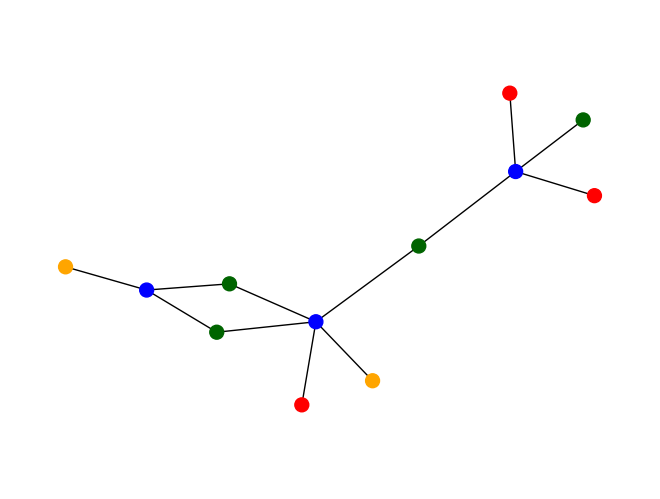

In [38]:
explanation_graph0 = plots.plot_graph(class0_graphid, max_pred0, 0, all_edges[class0_graphid],graph_dict[class0_graphid])

In [39]:
ind= utils.index_2d(softmax_dict[class0_graphid], max_pred0)[0]
list0= nodefeature_dict[class0_graphid]['author'].numpy()[ind]
Counter(list0)

Counter({0.0: 50})

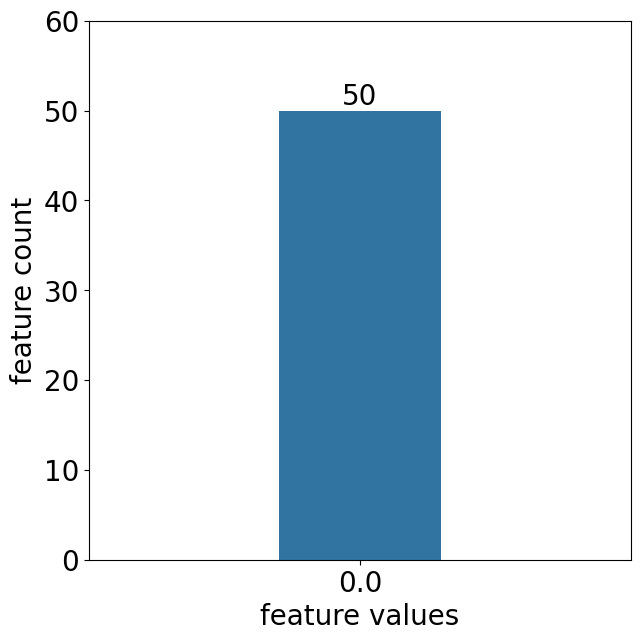

In [40]:
plots.count_plot(list0)

Number of nodes:  9
graph id:  sync580879211114_G12
Max pred probability for class 1 is 0.598174512386322


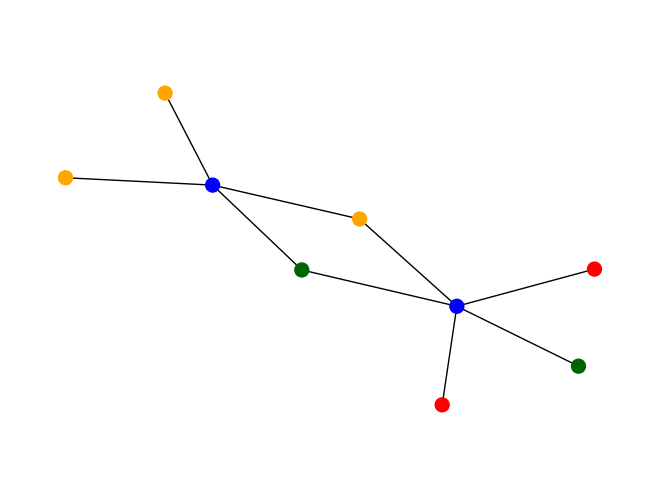

In [41]:
explanation_graph1 = plots.plot_graph(class1_graphid, max_pred1, 1, all_edges[class1_graphid],graph_dict[class1_graphid])

In [42]:
ind= utils.index_2d(softmax_dict[class1_graphid], max_pred1)[0]
list1= nodefeature_dict[class1_graphid]['author'].numpy()[ind]
Counter(list1)

Counter({0.0: 50})

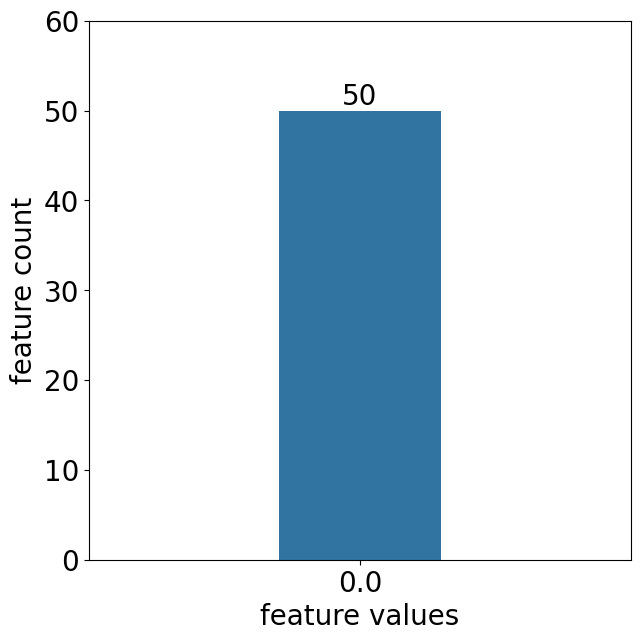

In [43]:
plots.count_plot(list1)

Number of nodes:  14
graph id:  sync386125211226_G14
Max pred probability for class 2 is 0.9964660406112671


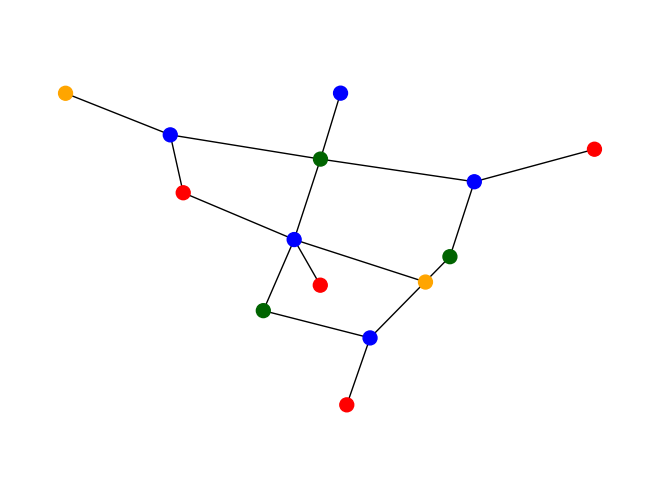

In [44]:
explanation_graph2 = plots.plot_graph(class2_graphid, max_pred2, 2, all_edges[class2_graphid],graph_dict[class2_graphid])

In [45]:
ind= utils.index_2d(softmax_dict[class2_graphid], max_pred2)[0]
list2= nodefeature_dict[class2_graphid]['author'].numpy()[ind]
Counter(list2)

Counter({0.0: 50})

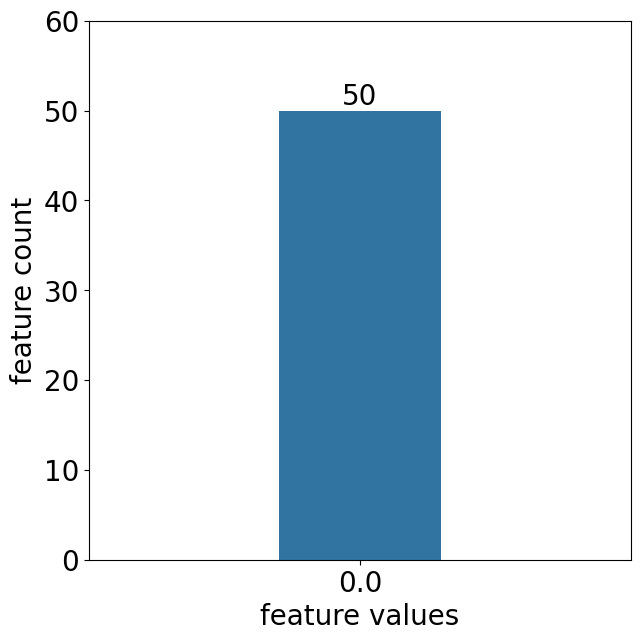

In [46]:
plots.count_plot(list2)

Number of nodes:  12
graph id:  sync40459211211_G13
Max pred probability for class 3 is 0.39020174741744995


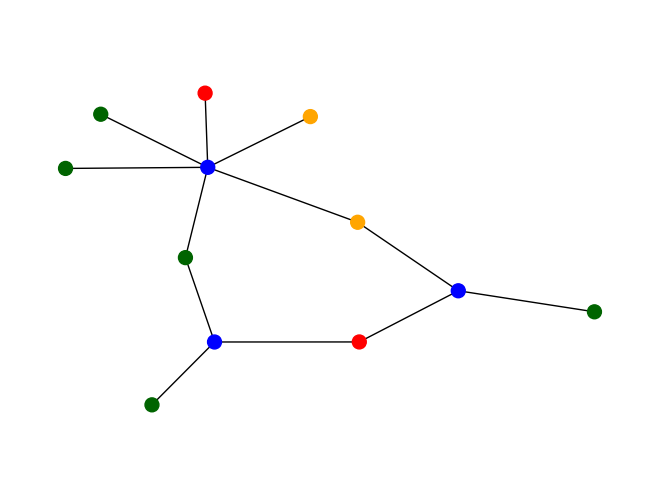

In [47]:
explanation_graph3 = plots.plot_graph(class3_graphid, max_pred3, 3, all_edges[class3_graphid],graph_dict[class3_graphid])

In [48]:
ind= utils.index_2d(softmax_dict[class3_graphid], max_pred3)[0]
list3= nodefeature_dict[class3_graphid]['author'].numpy()[ind]
Counter(list3)

Counter({0.0: 50})

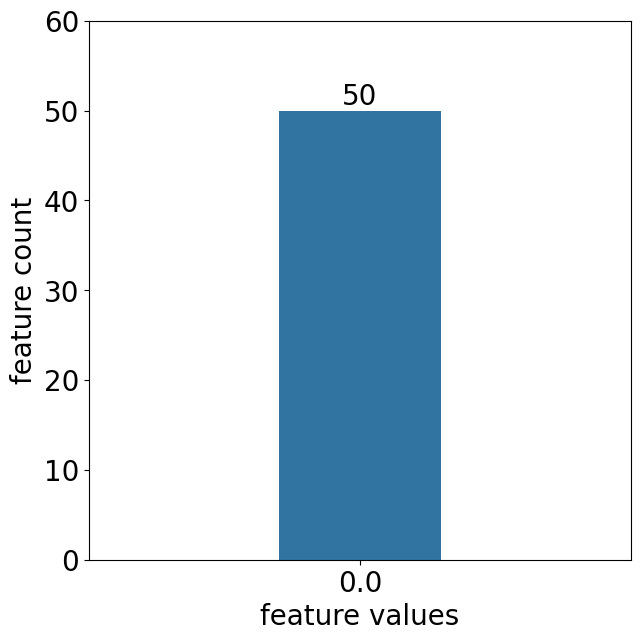

In [49]:
plots.count_plot(list3)

In [53]:
#Term Feature Statistics
term0_df = pd.DataFrame(nodefeature_dict[class0_graphid]['term'].numpy())
utils.print_stat_cont_features(term0_df)

mean 0.007247488
std dev 0.11566248


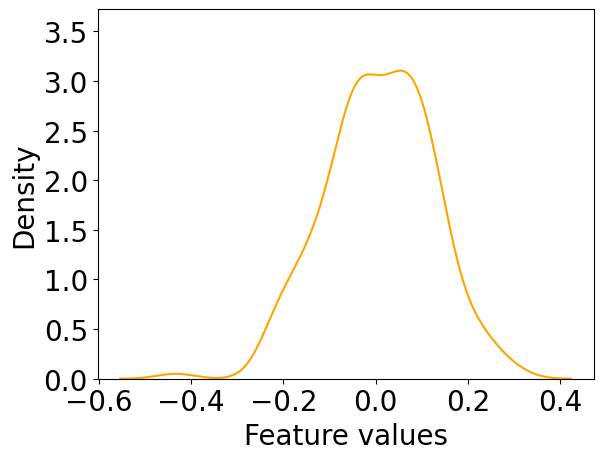

In [54]:
plots.plot_cont_feat(term0_df)

In [55]:
term1_df = pd.DataFrame(nodefeature_dict[class1_graphid]['term'].numpy())
utils.print_stat_cont_features(term1_df)

mean -0.0010737967
std dev 0.1471454


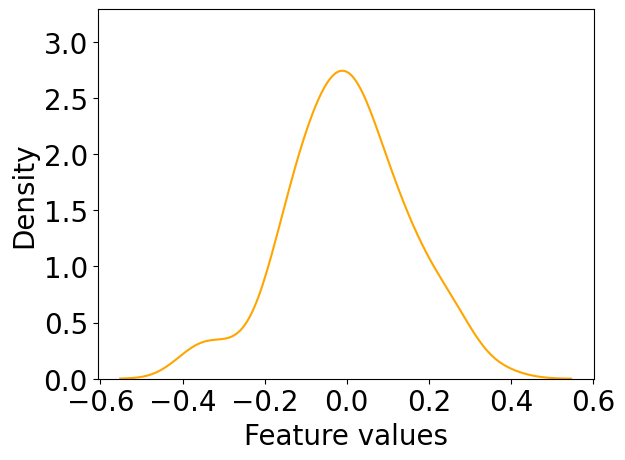

In [56]:
plots.plot_cont_feat(term1_df)

In [57]:
term2_df = pd.DataFrame(nodefeature_dict[class2_graphid]['term'].numpy())
utils.print_stat_cont_features(term2_df)

mean -0.0057854727
std dev 0.13237983


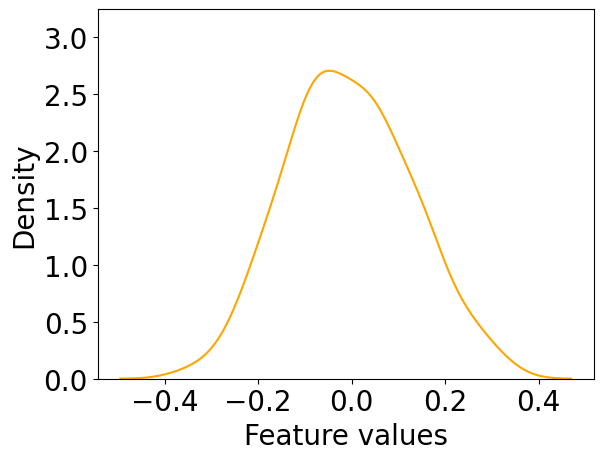

In [58]:
plots.plot_cont_feat(term2_df)

In [59]:
term3_df = pd.DataFrame(nodefeature_dict[class3_graphid]['term'].numpy())
utils.print_stat_cont_features(term3_df)

mean 0.010718769
std dev 0.13823962


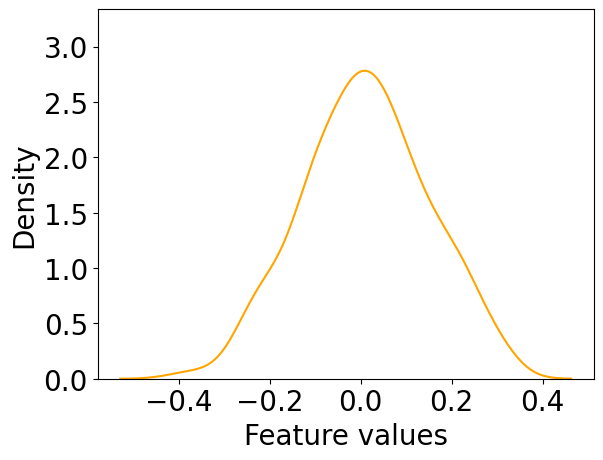

In [60]:
plots.plot_cont_feat(term3_df)

In [61]:
#Paper Features
paper0_df = pd.DataFrame(nodefeature_dict[class0_graphid]['paper'].numpy())

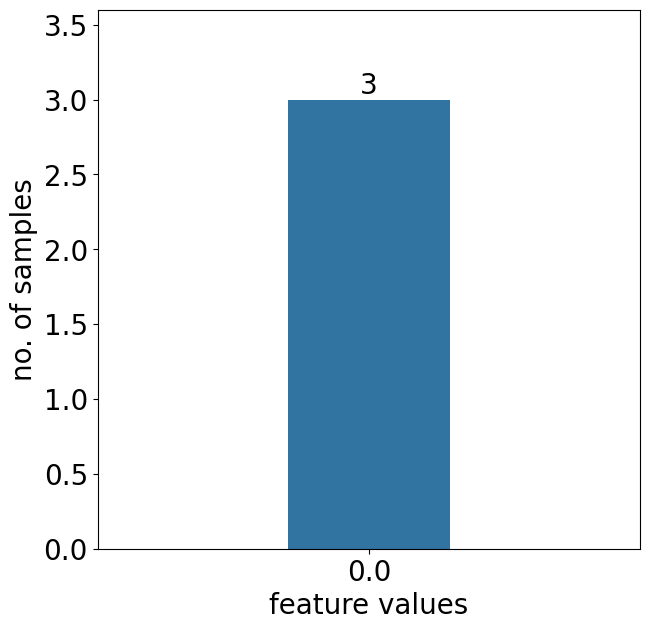

In [62]:
imp_paper_feat0=utils.selected_features_freq(paper0_df,1)
plots.plot_imp_feature(imp_paper_feat0.values.tolist())

In [63]:
paper1_df = pd.DataFrame(nodefeature_dict[class1_graphid]['paper'].numpy())

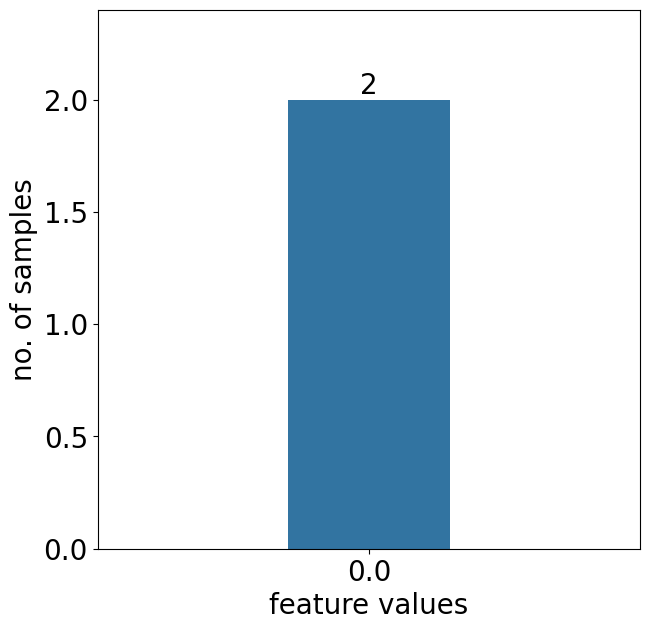

In [64]:
imp_paper_feat1=utils.selected_features_freq(paper1_df,1)
plots.plot_imp_feature(imp_paper_feat1.values.tolist())

In [65]:
paper2_df = pd.DataFrame(nodefeature_dict[class2_graphid]['paper'].numpy())

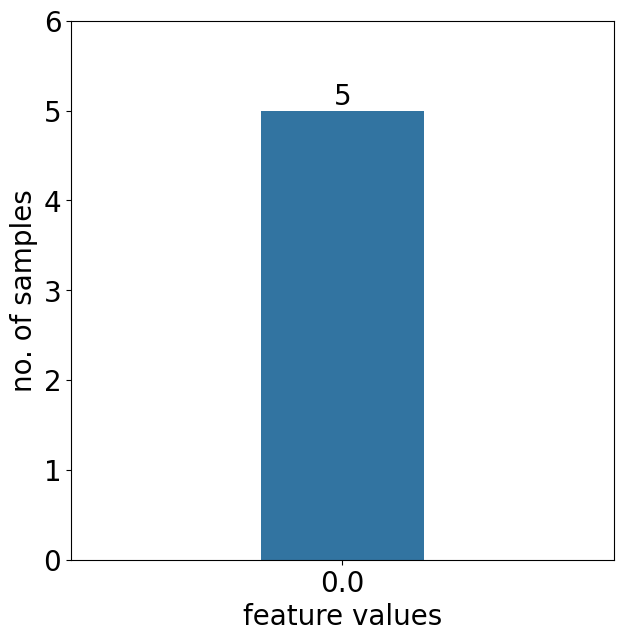

In [66]:
imp_paper_feat2=utils.selected_features_freq(paper2_df,1)
plots.plot_imp_feature(imp_paper_feat2.values.tolist())

In [67]:
paper3_df = pd.DataFrame(nodefeature_dict[class3_graphid]['paper'].numpy())

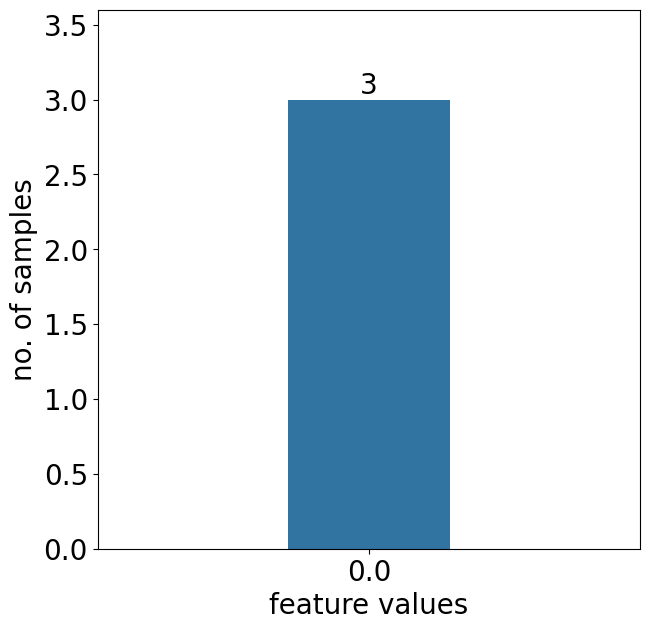

In [68]:
imp_paper_feat3=utils.selected_features_freq(paper3_df,1)
plots.plot_imp_feature(imp_paper_feat3.values.tolist())

In [4]:
motifs_path = '../../../../../common_motifs/dblp_10to15/'
files_motif = os.listdir(motifs_path)

In [5]:
for index_m, file_m in enumerate(files_motif):
    filepath_m = os.path.join(motifs_path, file_m)
    print(filepath_m)

../../../../../common_motifs/dblp_10to15/motif_real_10_0.gexf
../../../../../common_motifs/dblp_10to15/motif_real_10_1.gexf
../../../../../common_motifs/dblp_10to15/motif_real_10_2.gexf
../../../../../common_motifs/dblp_10to15/motif_real_10_3.gexf
../../../../../common_motifs/dblp_10to15/motif_real_10_4.gexf
../../../../../common_motifs/dblp_10to15/motif_real_11_0.gexf
../../../../../common_motifs/dblp_10to15/motif_real_11_1.gexf
../../../../../common_motifs/dblp_10to15/motif_real_11_2.gexf
../../../../../common_motifs/dblp_10to15/motif_real_11_3.gexf
../../../../../common_motifs/dblp_10to15/motif_real_11_4.gexf
../../../../../common_motifs/dblp_10to15/motif_real_12_0.gexf
../../../../../common_motifs/dblp_10to15/motif_real_12_1.gexf
../../../../../common_motifs/dblp_10to15/motif_real_12_2.gexf
../../../../../common_motifs/dblp_10to15/motif_real_12_3.gexf
../../../../../common_motifs/dblp_10to15/motif_real_12_4.gexf
../../../../../common_motifs/dblp_10to15/motif_real_13_0.gexf
../../..

In [75]:
faithfulness_list = []

for i in range(0,RUNS):
    faithfulness = utils.get_faithfulness_common(class_graphid_list[i],all_edges_list[i],motifs_path)

    print('Run'+str(i),faithfulness)
    faithfulness_list.append(faithfulness)
print('Mean',np.mean(faithfulness_list))

Run0 0.6166666666666667
Run1 0.6833333333333333
Run2 0.6583333333333333
Run3 0.6833333333333333
Run4 0.5666666666666667
Run5 0.6833333333333333
Run6 0.5
Run7 0.4166666666666667
Run8 0.6833333333333333
Run9 0.6333333333333333
Mean 0.6125


In [76]:
print('Standard Deviation',np.std(faithfulness_list))

Standard Deviation 0.08702250666733674
